# Analysis of threat reports
This notebook contains cells to analyse threat reports on the threats and actors they describe.

### Build initial threat- and actor list from spreadsheet

In [1]:
import pandas as pd

file = "Threat reports.xlsx"
reports = pd.ExcelFile(file).parse('Threat reports')

In [2]:
# Build the lists
threatlist = []
actorlist = []
year = 2021

# Filter on one year
reports=reports[reports['reported year'] == year]

for index, row in reports.iterrows():
    threats = row['threats']
    if not pd.isna(threats):
        for threat in threats.split(", "):
            if threat not in threatlist and threat != "":
                threatlist.append(threat)

    actors = row['actors']
    if not pd.isna(actors):
        for actor in actors.split(", "):
            if actor not in actorlist and actor != "":
                actorlist.append(actor)

threatlist.sort()
actorlist.sort()
print("Threats:\n",threatlist)
print("Threat actors:\n",actorlist)

Threats:
 ['C2', 'DDoS', 'account compromise', 'adware', 'backdoor', 'banking trojan', 'botnet', 'brand abuse', 'brute force', 'business email compromise', 'capture app data', 'coinminers', 'credential harvesting', 'crypto malware', 'data exposure on code repositories', 'denial of service', 'fleeceware', 'information stealers', 'local code execution', 'malicious insider', 'misconfiguration', 'misdelivery', 'network infrastructure compromise', 'network pivot', 'password spraying', 'phishing', 'pretexting', 'privilege abuse', 'proxy shell', 'ransomware', 'remote access trojan', 'remote access trojans', 'remote code execution', 'rootkits', 'scams', 'server access', 'supply chain attack', 'system compromise', 'targeted threats on remote work', 'technical support cams', 'trojan', 'use of stolen credentials', 'vulnerability exploitation']
Threat actors:
 ['APT15', 'APT28', 'APT31', 'APT32', 'APT40', 'APT5', 'Aquatic Panda', 'Astro Locker Team', 'Bitwise Spider', 'BlackShadow', 'Carbon Spider

### PDF Scanner

#### Init dictionaries

In [5]:
import PyPDF2
import os

report_folder = "reports\\2021"
report_list = [file for file in os.listdir(report_folder) if file.endswith(".pdf")]

## Init threat dictionary to count occurences of threats per report
report_dict = {}  
for i in report_list:
    threat_dict = {}
    for j in threatlist:
        threat_dict[j] = 0
    report_dict[i] = threat_dict


In [6]:

# Iterate over PDFs in the folder
for file in report_list:
     print("Processing: ",file)
     search_term = threatlist[0]

     reader = PyPDF2.PdfFileReader(report_folder+"\\"+file)
     for page_number in range(0, reader.numPages):
          page = reader.getPage(page_number)
          page_content = page.extractText()
          for search_term in threatlist:
               if search_term in page_content:
                    report_dict[file][search_term] += 1

df = pd.DataFrame(report_dict)
display(df)

Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Blackberry.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Bugcrowd.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Crowdstrike.pdf
Processing:  CTM360.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Deepwatch.pdf
Processing:  ENISA.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Fortinet-2021H1.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Fortinet-2021H2.pdf
Processing:  IBM.pdf
Processing:  Microsoft.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  PaloAltoNetworks.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


Processing:  Rapid7.pdf
Processing:  Verizon.pdf


,Blackberry.pdf,Bugcrowd.pdf,Crowdstrike.pdf,CTM360.pdf,Deepwatch.pdf,ENISA.pdf,Fortinet-2021H1.pdf,Fortinet-2021H2.pdf,IBM.pdf,Microsoft.pdf,PaloAltoNetworks.pdf,Rapid7.pdf,Verizon.pdf
C2,8,0,5,0,1,4,1,2,1,1,3,0,3
DDoS,2,0,0,0,0,31,1,0,6,7,2,0,10
account compromise,0,0,0,0,0,0,0,0,0,0,0,0,0
adware,0,0,0,0,0,4,0,0,3,2,0,0,0
backdoor,2,0,0,0,0,3,2,0,2,2,1,2,2
banking trojan,0,0,0,0,0,0,1,0,5,1,0,0,0
botnet,0,0,1,0,0,18,4,4,7,5,0,0,6
brand abuse,0,0,0,0,0,0,0,0,0,0,0,0,0
brute force,1,0,0,1,0,1,0,0,5,1,1,0,1
business email compromise,0,0,0,0,0,0,0,1,1,1,3,0,2


## Display statistics

<Figure size 640x480 with 0 Axes>

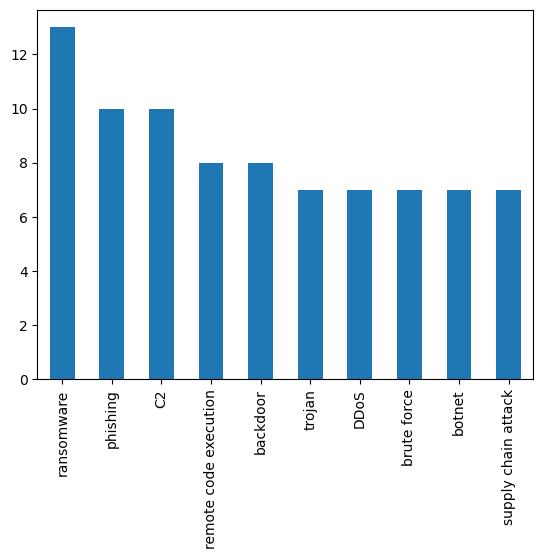

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import numpy as np

threat_occurences = df.gt(0).sum(axis=1)
threat_occurences.sort_values(inplace=True)

# Plot
threat_occurences.nlargest(10).plot(kind="bar")
plt.figure()


1101